Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# Lastfm

In [3]:
# importa dataset 'lastfm playlists'
data = pd.read_csv("../datasets/lastfm_50u.tsv","\t")
dataset_name = 'Lastfm'
user_col = 'user_id'
item_col = 'item_id'

In [14]:
data.shape

(1121520, 7)

In [4]:
# Necessary Preprocess - create date from timestamp
data['date2'] = data['timestamp'].apply(lambda x: datetime.strptime(x.split('T')[0], '%Y-%m-%d') )
data['year'] = data['date2'].dt.year
data['month'] = data['date2'].dt.month
data['date'] = data[['year', 'month']].apply(lambda x: datetime.strptime( str(x[0])+'/'+str(x[1]), '%Y/%m' ) , axis=1)

In [5]:
# this lets me sample the first 10% of the dataset to avoid cold start.
# data.iloc[ :int( 0.1*data.shape[0] ) ]

## Evaluating Time defined Buckets 

How many interactions occur in each month?

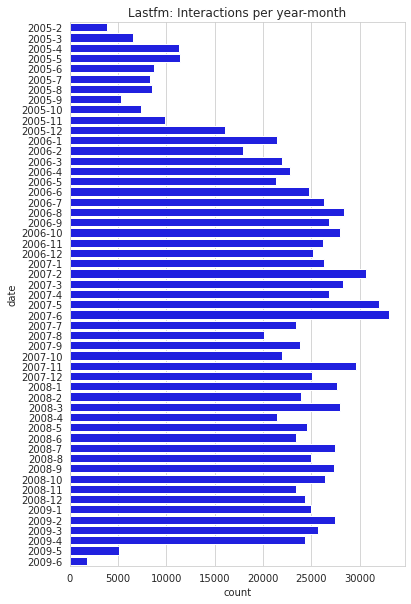

In [8]:
plot_interactions_per_month(data=data, dataset_name=dataset_name)

In [11]:
# FILTERING USERS WITH AT LEAST 5 INTERACTIONS
# data['user_id'].value_counts() >= 5

In [12]:
k_core_users = data['user_id'].value_counts()[ data['user_id'].value_counts() >= 5 ].index

In [13]:
data = data.set_index('user_id').loc[k_core_users].reset_index()

In [15]:
data.shape

(1121520, 7)

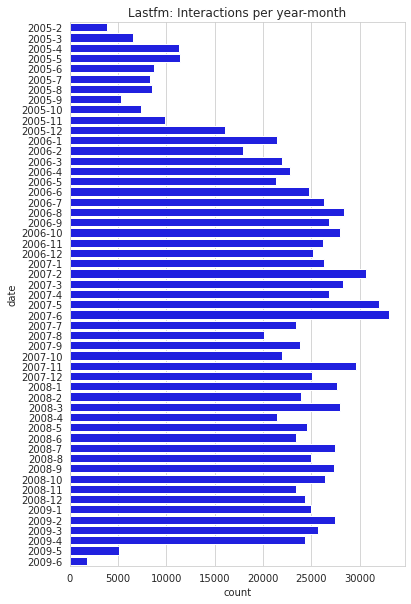

In [16]:
plot_interactions_per_month(data=data, dataset_name=dataset_name)

Filtering dataset - selected months

In [17]:
# y_filter = (data['date'] < datetime.strptime('2018', '%Y')) & (datetime.strptime('2014', '%Y') <= data['date']) 
# y_filter = (data['date'] < datetime.strptime('2015-01', '%Y-%m')) & (datetime.strptime('2014-01', '%Y-%m') <= data['date']) 
y_filter = (data['date2'] < datetime.strptime('2008-07', '%Y-%m')) & (datetime.strptime('2008-01', '%Y-%m') <= data['date']) 

In [18]:
y_filter.sum()

149042

In [19]:
data = data[y_filter.tolist()]

In [20]:
# number of remaining cases
data.shape[0]

149042

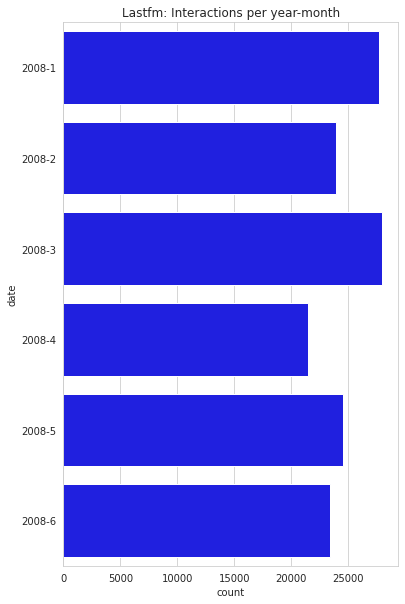

In [21]:
plot_interactions_per_month(data=data, dataset_name=dataset_name)

Sampling the dataset - only most frequent users (overall)

In [22]:
user_freq_over_months = data.groupby(by=['user_id'])['date'].nunique()

CPU times: user 16.7 ms, sys: 725 µs, total: 17.5 ms
Wall time: 15.7 ms


<AxesSubplot:ylabel='Frequency'>

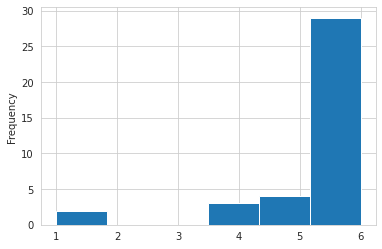

In [23]:
user_freq_over_months.plot(kind='hist',bins=user_freq_over_months.max())

In [24]:
_ = data.set_index('user_id').copy()

<AxesSubplot:>

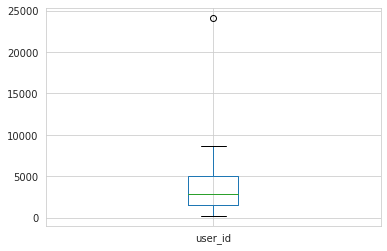

In [25]:
# frequency of users that occur every month:
_.reset_index()['user_id'].value_counts().plot(kind='box')

In [26]:
u = data['user_id'].value_counts().reset_index()['index'].to_list()

In [27]:
# to user, or not to use p ?
p = (data['user_id'].value_counts()/data['user_id'].shape[0])

In [28]:
prop = 0.75
s = round( len( u )*prop )

In [29]:
np.random.seed(42)
sampled_users = list( np.random.choice(u, size=s, replace=False, p=p) ) # , p=p

In [30]:
_.loc[sampled_users].shape

(136724, 6)

In [32]:
_.loc[sampled_users][item_col].nunique()

44047

<AxesSubplot:>

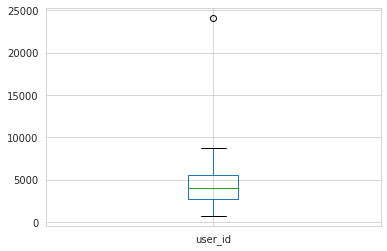

In [33]:
# frequency of users:
_.loc[sampled_users].reset_index()[user_col].value_counts().plot(kind='box')

CPU times: user 79.4 ms, sys: 0 ns, total: 79.4 ms
Wall time: 77.3 ms


<AxesSubplot:ylabel='Frequency'>

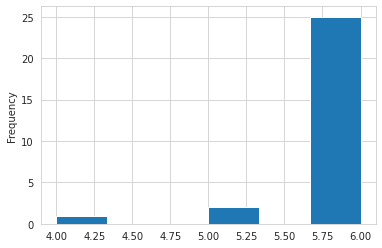

In [34]:
%%time
# ( data[:1000000].groupby(by=['user_id'])['date'].nunique() > 1 ).sum()
user_freq_over_months_sample = _.loc[sampled_users].reset_index().groupby(by=['user_id'])['date'].nunique()
user_freq_over_months_sample.plot(kind='hist',bins=user_freq_over_months_sample.max())

In [36]:
data[user_col].nunique(), data[item_col].nunique() # original number of users, original number of items

(38, 48404)

In [37]:
# _.loc[freq_users].reset_index()['user_id'].nunique(), _.loc[freq_users].reset_index()['item_id'].nunique() # sample number of users, and of items
_.loc[sampled_users].reset_index()[user_col].nunique(), _.loc[sampled_users].reset_index()[item_col].nunique() # sample number of users, and of items

(28, 44047)

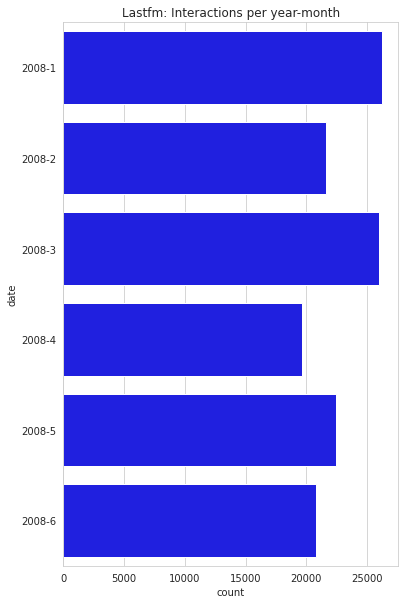

In [38]:
# %%time
# plot_interactions_per_month(data=_.loc[freq_users].reset_index(), dataset_name=dataset_name)
plot_interactions_per_month(data=_.loc[sampled_users].reset_index(), dataset_name=dataset_name)

In [39]:
USE_THRESHOLD = False
# all users 0.303427
# USING prop = 0.75 , .305128
# USING prop = 0.5, 0.315315

if USE_THRESHOLD: 
    data = _.loc[sampled_users].reset_index()
    data = data.sort_values(by=['timestamp', user_col, item_col])
    print(data.shape[0])
else:
    print(data.shape[0])
# new sample
data.to_csv('output/lastfm_dump/sampled_lastfm.csv', index=False)

149042


How many interactions occur in each month / year?

In [40]:
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()

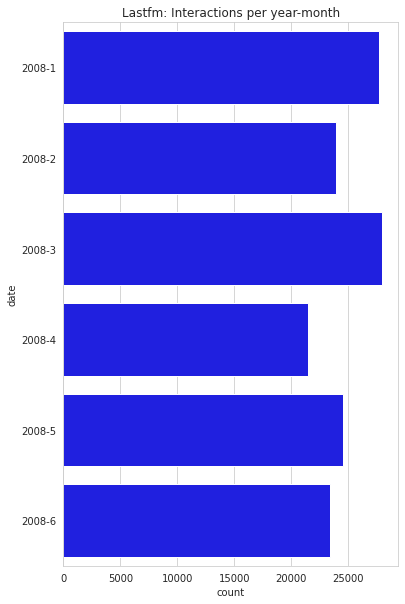

In [41]:
plot_interactions_per_month(data=data, dataset_name=dataset_name)

What is the user presence distribution based on month, quarter, and semester?

In [42]:
%%time
# 3min 16s
user_presence_df, user_month_interactions = get_interactions_info(data=data, user_col=user_col)

# new sample
user_presence_df.to_csv('output/lastfm_dump/sample_user_presence_df.csv', index=False)
user_month_interactions.to_csv('output/lastfm_dump/sample_user_month_interactions.csv', index=False)

0.0 %
50.0 %
CPU times: user 71.5 ms, sys: 10.2 ms, total: 81.6 ms
Wall time: 74.5 ms


In [43]:
user_presence_df.head()

,UserID,month_%
0,user_000001,1.0
1,user_000453,1.0
2,user_000019,1.0
3,user_000141,1.0
4,user_000986,1.0


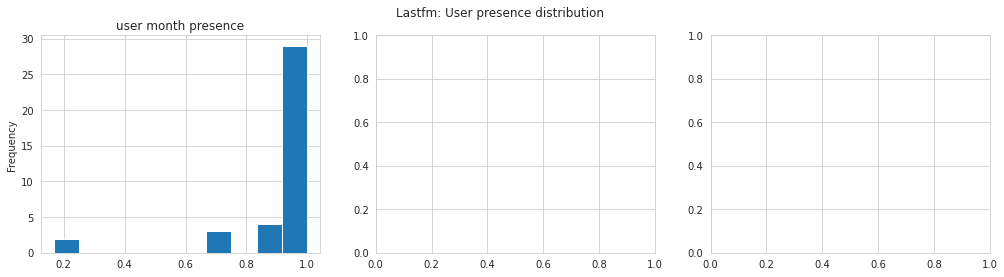

In [44]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name=dataset_name)

How many examples are there per quarter and semester?

In [45]:
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name=dataset_name, type_of_range='quarter')

In [46]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name=dataset_name, type_of_range='semester')

How many FREQUENT users (occur in 80% or more intervals) exist?

In [47]:
# defining threshold
frequency_threshold = 1

In [48]:
# frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)
frequent_users_month = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

29 users of 38 (76.316%) occurr in 100% or more months.


In [49]:
# old huge sample
# joblib.dump(frequent_users_month, 'output/amazonbooks_dump/frequent_users_month.joblib')

# new sample
joblib.dump(frequent_users_month, 'output/lastfm_dump/sample_frequent_users_month.joblib')

['output/lastfm_dump/sample_frequent_users_month.joblib']

___

<!-- What is the user presence distribution based on month, quarter, and semester?
user_presence_df, user_month_interactions, trimestres, user_trimestre_interactions, semestres, user_semestre_interactions = get_interactions_info(data=data, user_col=user_col)
user_presence_df.head()
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name=dataset_name)
How many examples are there per quarter and semester?
plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name=dataset_name, type_of_range='quarter')
plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name=dataset_name, type_of_range='semester')
How many FREQUENT users (occur in 80% or more intervals) exist?
# defining threshold
frequency_threshold = 0.8
frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)
In median terms, how many times FREQUENT users appear in each quarter, and semester?
freq_user_quarter_info = get_frequent_user_statistics(
    interactions_df=user_trimestre_interactions, frequent_users_list=frequent_users_trimestre)
# freq_user_quarter_info
freq_user_quarter_info['median_freq_user_interactions'].plot(kind='bar')
freq_user_quarter_info['freq_users_at_least_1_interaction'].plot(kind='bar')
# # frequent user interaction per quarter
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions.loc[frequent_users_trimestre],
#     date_range=trimestres)
freq_user_semester_info = get_frequent_user_statistics(
    interactions_df=user_semestre_interactions, frequent_users_list=frequent_users_semestre)
# freq_user_semester_info
freq_user_semester_info['median_freq_user_interactions'].plot(kind='bar')
freq_user_semester_info['freq_users_at_least_1_interaction'].plot(kind='bar')
# plot_interactions_per_qns(user_interactions=user_semestre_interactions.loc[frequent_users_semestre], date_range=semestres, type_of_range='semester')
# these are the users that should be used in holdouts, and only their last interactions
# BUT, there are users that do not appear in some intervals, and some have only one interaction
user_trimestre_interactions.loc[frequent_users_trimestre]
user_semestre_interactions.loc[frequent_users_semestre];
## Evaluating Interactions 50E3 sized Buckets 
n_iter_bucket = 50E3

interval_start, interval_end = get_bucket_intervals(data, n_iter_bucket)    
How many users per bucket?    
plot_users_per_fixed_bucket(data, user_col, interval_start, interval_end)
How many FREQUENT users (occur in 80% or more intervals) exist?
user_bucket_interactions_df, dates_fixed_buckets_df = get_fixed_buckets_info(data, user_col, interval_start, interval_end)
frequency_threshold = 0.8
frequent_users_bucket = get_frequent_users_fixed_buckets(user_bucket_interactions_df, frequency_threshold)
In median terms, how many times FREQUENT users appear in each bucket?
freq_user_bucket_info = get_frequent_user_statistics(user_bucket_interactions_df, frequent_users_bucket)
freq_user_bucket_info['median_freq_user_interactions'].plot(kind='bar')
freq_user_bucket_info['freq_users_at_least_1_interaction'].plot(kind='bar')
# frequent users interactions per bucket
plot_user_interactions_per_bucket(user_bucket_interactions_df, frequent_users_bucket)
Which timestamps occur in each bucket?
plot_timestamps_per_bucket(dates_fixed_buckets_df)
___
## Store Buckets
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
stream = ImplicitData(data['user_id'], data['item_id'])

empty_stream = ImplicitData([], [])
num_factors = 160
num_iter = 4
learn_rate = 0.5
regularization = 0.4
num_nodes = 8
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_lastfm = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics = ["Recall@N"], N_recommendations=20, seed=42)
_=eval_lastfm.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 441 min
joblib.dump(eval_lastfm, 'output/joblib_bucket_info_dump/eval_lastfm', compress=True) -->